<img src='../img/acam_banner.png' alt='ACAM Training School' align='right' width='60%'></img>

<br>

<hr>

# Sentinel-3 SLSTR - Near-Real-Time Fire Radiative Power (FRP) - Level 2

### About

The [Copernicus Near-Real-Time Sentinel 3 Fire Radiative Power](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) product identifies the location, and quantifies the radiative power, of any hotspot present on land and ocean Earth surfaces, that radiates a heating signal within a pixel size of 1 km<sup>2</sup>. The product is retrieved from observations from the SLSTR instrument onboard Sentinel-3A and Sentinel-3B.

All threatening hotspots are identified and characterised within three hours from the sensing time. The product identifies fire hotspots emitting radiations from MWIR (3.7 um) and SWIR (2.25 um). Hotspot identfied by the MWIR channel are typically less intensive fires with a temperature less than 1100 Kelvin, whereas hotspot identified by the SWIR channel are more intensive fires with a temperature above 1100 Kelvin.

Get more product specifications [here](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207).

The notebook features Fire Radiative Power locations identified over Laos on 21 April 2023.

### Basic Facts

> **Spatial resolution**: `FRP_MWIR: 1km x 1km, FRP_SWIR: 1km x 1km and 500m x 500m` <br>
> **Spatial coverage**: `Global (ocean and land surfaces)` <br>
> **Revisit time**:  `daily, 3 hours after sensing time` <br>
> **Data availability**: `since April 2020`


### How to access the data

The Sentinel-3 SLSTR Near Real Time Level 2 Fire Radiative Power product is disseminated as zipped archives and can be downloaded via the [EUMETSAT Data Store](https://data.eumetsat.int/data/map/EO:EUM:DAT:0417). You have to [create an account](https://eoportal.eumetsat.int/userMgmt/register.faces) for the EUMETSAT Earth Observation Portal.

### Module outline:
* [1 - Load Sentinel-3 SLSTR FRP data](#load_s3_frp)
* [2 - Load, mask and regrid FRP computed from MWIR channel (3.7 um)](#load_mwir)

<hr>

#### Load required libraries

In [25]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [4]:
%run ../functions.ipynb

<hr>

## <a id='load_s3_frp'></a>Load Sentinel-3 SLSTR Near-Real-Time FRP data

[OPTIONAL] The first step is to unzip the files from the zipped archive downloaded. This is optional as we have already unzipped the file for you. This is why the code is commented out.

The zipped archive contains data in the `netCDF` format. The day for which data was requested is 21 April 2023.

In [1]:
#import zipfile
#with zipfile.ZipFile('../../eodata/acam_training_school/S3_frp/S3A_SL_2_FRP____20230421T151148_20230421T151648_20230421T162953_0299_098_054______MAR_O_NR_002.SEN3.zip', 'r') as zip_ref:
#    zip_ref.extractall('../../eodata/acam_training_school/S3_frp/')

<br>

The next step is to load the data file with xarray's `open_dataset()` function. Once the data file is loaded, you see that the data file has five dimensions: `columns`, `fires`, `rows`, `fires_MWIR_alternative` and `fires_SWIR_500m`. The data and additional information, such as quality flags or latitude and longitude information, is stored as part of the 61 data variables.

There are three variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW] --> fires with temperatures < 1100 Kelvin
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW] --> fires with temperatures > 1100 Kelvin

In [26]:
frp_dir = '../../eodata/acam_training_school/S3_frp/S3A_SL_2_FRP____20230421T151148_20230421T151648_20230421T162953_0299_098_054______MAR_O_NR_002.SEN3/'
frp_xr = xr.open_dataset(frp_dir+'FRP_in.nc')
frp_xr

<xarray.Dataset>
Dimensions:                             (fires: 1367, fires_MWIR_alternative: 941, fires_SWIR_500m: 1204, rows: 2000, columns: 1500)
Dimensions without coordinates: fires, fires_MWIR_alternative, fires_SWIR_500m, rows, columns
Data variables: (12/61)
    i                                   (fires) int16 ...
    j                                   (fires) int32 ...
    time                                (fires) datetime64[ns] ...
    latitude                            (fires) float64 ...
    longitude                           (fires) float64 ...
    latitude_alternative                (fires_MWIR_alternative) float64 ...
    ...                                  ...
    sat_azimuth                         (fires) float64 ...
    solar_zenith_alternative            (fires_MWIR_alternative) float64 ...
    solar_azimuth_alternative           (fires_MWIR_alternative) float64 ...
    sat_zenith_alternative              (fires_MWIR_alternative) float64 ...
    sat_azimuth_alternative             (fires_MWIR_alternative) float64 ...
    flags                               (rows, columns) uint32 ...
Attributes: (12/17)
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20230421T151148_20230421T151648_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 03.01
    ...                     ...
    absolute_orbit_number:  37372
    start_time:             2023-04-21T15:11:47.956454Z
    stop_time:              2023-04-21T15:16:47.942851Z
    processing_baseline:    FRP_NRT.002.01.00
    track_offset:           998
    start_offset:           700

#### Load `latitude` and `longitude` information

You can already load the `latitude` and `longitude` information, which will be required for the regridding process.

In [28]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lon_frp

<xarray.DataArray 'longitude' (fires: 1367)>
array([ 98.404267,  98.60536 ,  98.899658, ..., 102.631852, 102.619162,
       102.633605])
Dimensions without coordinates: fires
Attributes:
    long_name:      FRP Longitude - Standard MWIR only, or Standard MWIR comm...
    standard_name:  FRP_longitude_Standard_MWIR
    units:          degrees_east
    valid_min:      -180.0
    valid_max:      180.0

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [29]:
sampling_lat_FRP_grid = 0.15        # Sampling for gridded FRP values & different stats computation 
sampling_lon_FRP_grid = 0.15        # Sampling for gridded FRP values & different stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots

lat_min               = 5.        # Minimum latitude for mapping plot [deg N]
lat_max               = 35.        # Maximum latitude for mapping plot [deg N]
lon_min               = 80.        # Minimum lonitude for mapping plot [deg E]
lon_max               = 120.        # Maximum lonitude for mapping plot [deg E]

Now, let us go through the `MWIR` variable and let us load, mask, regrid and visualize them.

## <a id='load_mwir'></a>Load, mask and regrid FRP computed from the MWIR channel (3.7 um)

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. Once loaded, you see that 1367 fire hotspots were located.

In [31]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 1367)>
array([1.524809, 8.104325, 3.591057, ..., 8.454308, 4.633431, 3.236346])
Dimensions without coordinates: fires
Attributes:
    long_name:  Standard Fire Radiative Power (FRP) MWIR - The reference FRP ...
    units:      MW

### Generate a gridded FRP array

Let us now comput the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can use the function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding), which generates, when applied to the `frp_mwir` variables, gridded fire radiatve power information.

In [33]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array = frp_mwir, 
                                                       parameter = 'mwir', 
                                                       lat_min = lat_min, 
                                                       lat_max = lat_max, 
                                                       lon_min = lon_min, 
                                                       lon_max = lon_max, 
                                                       sampling_lat_FRP_grid = sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid = sampling_lon_FRP_grid, 
                                                       n_fire = n_fire_MWIR,
                                                      lat_frp=lat_frp,
                                                      lon_frp=lon_frp)
FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[ 5.075,  5.075,  5.075, ...,  5.075,  5.075,  5.075],
        [ 5.225,  5.225,  5.225, ...,  5.225,  5.225,  5.225],
        [ 5.375,  5.375,  5.375, ...,  5.375,  5.375,  5.375],
        ...,
        [34.775, 34.775, 34.775, ..., 34.775, 34.775, 34.775],
        [34.925, 34.925, 34.925, ..., 34.925, 34.925, 34.925],
        [35.075, 35.075, 35.075, ..., 35.075, 35.075, 35.075]],
       dtype=float32),
 array([[ 80.075,  80.225,  80.375, ..., 119.675, 119.825, 119.975],
        [ 80.075,  80.225,  80.375, ..., 119.675, 119.825, 119.975],
        [ 80.075,  80.225,  80.3

<br>

The next step is to mask out the invalid pixels (-9999) for plotting. You can use numpy's function `np.ma.masked_array()` to mask out unwanted values.

In [34]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir          = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

<br>

Now, based on the gridded FRP information, we can compute some statistics and generate a string that can be added to the final plot.

In [35]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum      = np.sum(frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'

### Visualize the masked data array with matplotlib's `pcolormesh()` function

The last step is to visualise the gridded Fire Radiative Power hotspots. You can use the function [visualize_s3_frp](../functions.ipynb#viusalize_s3_frp) and plot the `FRP computed from MWIR channel` data. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

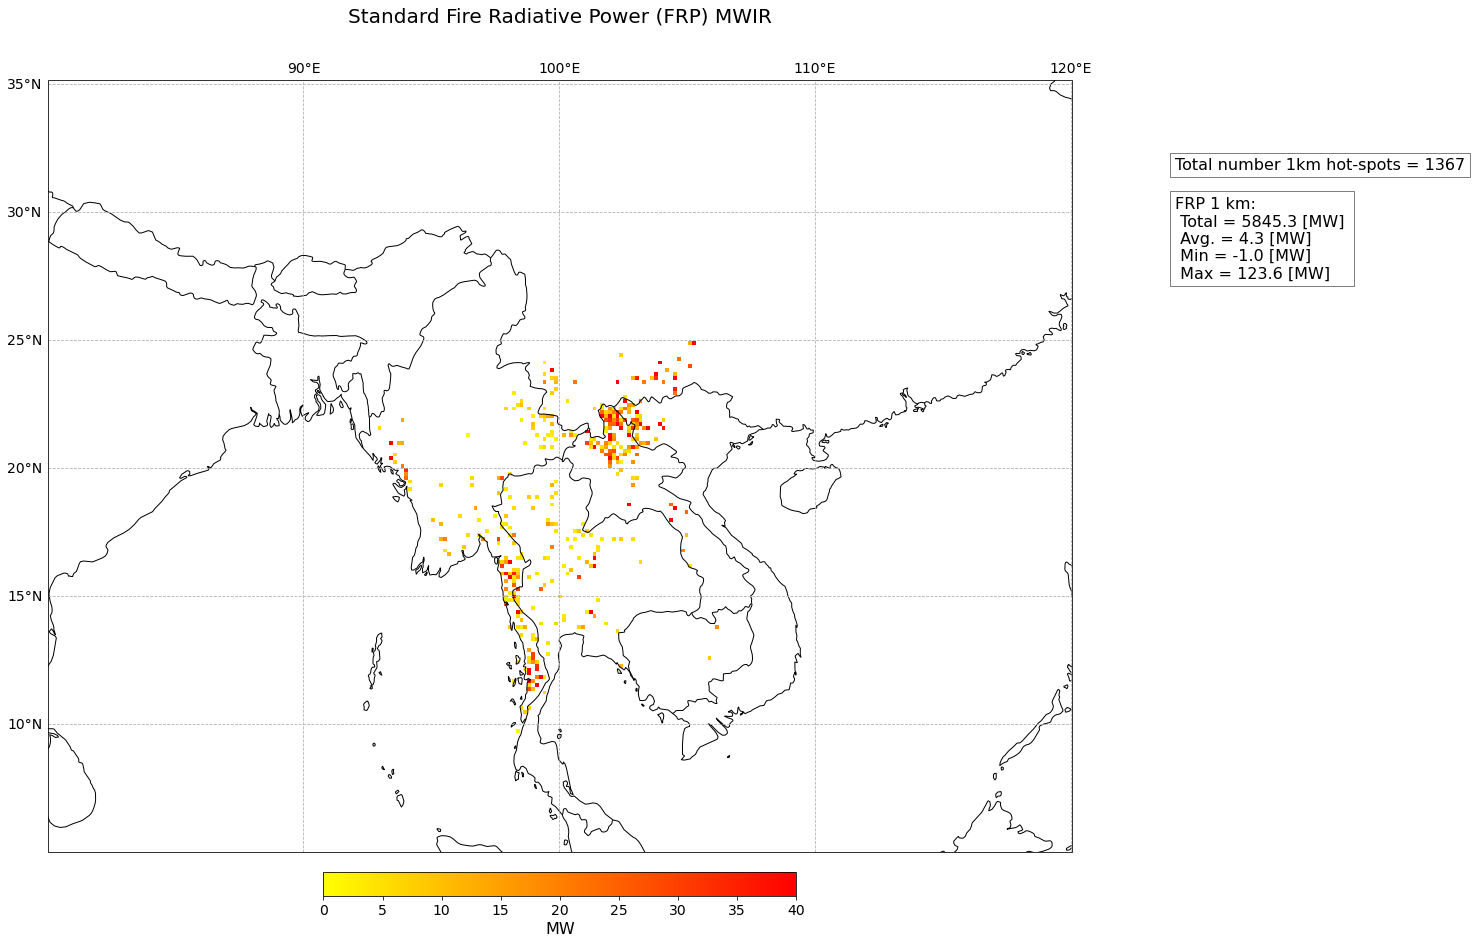

In [36]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data = D_mwir[:,:],
                 lat = lat_grid, 
                 lon = lon_grid, 
                 unit = unit, 
                 longname = long_name[0:40], 
                 textstr_1 = textstr_1, 
                 textstr_2 = textstr_2, 
                 vmax = FRP_plot_max_grid)

<hr>

### References
* EUMETSAT (2022): Release of Collection 2.1 of S3 NRT Fire Radiative Power. https://www.eumetsat.int/S3-NRT-fire-radiative-power-collection-2.1-release

<hr>

<img src='../img/acam_banner.png' alt='Logo EU Copernicus' align='left' width='30%'><br><br><br><br><br>
This project is licensed under <a href="../LICENSE">MIT License</a> and is developed under a Copernicus contract.

<p style="text-align:right;"> <a href='https://training.eumetsat.int'>EUMETSAT Training</a> | <a href='mailto:training@eumetsat.int'>Contact the training team</a></p>